# Aprendizaje Automático para Datos en Grafos - Laboratorio 5
## Introducción a Graph Neural Networks (GNNs)


En este laboratorio vamos a construir una Graph Neural Network (GNN) utilizando la biblioteca PyTorch Geometric (PyG).

Luego aplicaremos nuestro modelo a un conjunto de datos extraido de Open Graph Benchmark (OGB) con el fin de hacer predicciones sobre propiedades de los nodos.

## Setup

Sugerimos usar GPU para disminuir el tiempo de ejecución. Para eso, ir a `Runtime`->`Change runtime type` y en `Hardware accelerator` seleccionar **GPU**.


In [2]:
# Instalo PyTorch Geometric y OGB
!pip install torch-geometric
!pip install ogb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 7.9 MB/s eta 0:00:00


In [6]:
# Importo bibliotecas
import torch
import torch.nn as nn
import torch_geometric as pyg
from torch_geometric.nn import TAGConv, LayerNorm, Sequential
from torch_geometric.nn.conv import MessagePassing

## Graph Convolution

El operador más importante para entender una GNN es la convolución a nivel de grafo (*graph convolution*). A partir del grafo definimos el denominado *graph shift operator* (GSO) $\mathbf{S}$, que se usará para difundir la señal entre los nodos. En este caso en particular es simplemente la matriz de adyacencia del grafo con algunas normalizaciones habituales.

La convolución se define entonces como
> $$\mathbf{y} = \sum_{k=0}^{K} \mathbf{S}^k \mathbf{x} h_k,$$

donde $\mathbf{x}$ e $\mathbf{y}$ son señales en el grafo y $h_k\in\mathbb{R}$ son los coeficientes del filtro. Recordar que $\mathbf{S}^k_{i,j}$ será distinto de cero si hay un camino de largo $k$ entre los nodos $i,j$. Esto quiere decir que $K$, el orden del filtro, indica de qué tan lejos traemos información al calcular la convolución. Los coeficientes $h_k$ son simplemente cuánto peso le damos a la información a distancia $k$. Para quienes estudiaron procesamiento de señales, la analogía con la convolución en tiempo discreto y el operador $z^{-1}$ debería terminar de aclarar la ecuación.


La definión dada anteriormente, también se puede extender a señales con varias dimensiones (o **canales**, en la nomenclatura de las CNNs).  En este caso la señal será una matriz $\mathbf{X}\in\mathbb{R}^{n\times F_{in}}$ (o un vector de dimensión $F_{in}$ por nodo) y lo único que hay que modificar levemente es la definición de convolución:
> $$\mathbf{Y} = \sum_{k=0}^{K} \mathbf{S}^k \mathbf{X} \mathbf{H}_k,$$

donde $\mathbf{H}_k\in\mathbb{R}^{F_{in}\times F_{out}}$ es la matriz de coeficientes del filtro. Por lo tanto $\mathbf{Y}\in\mathbb{R}^{n\times F_{out}}$ sigue siendo una señal en el grafo, pero de $F_{out}$ dimensiones.


Comenzaremos construyendo nuestro propio módulo para calcular la convolución a nivel de grafo. Para simplificar, definimos nuestro graph shift operator como:

> $$\mathbf{S}=\mathbf{A}$$

donde $\mathbf{A}$ es la matriz de adyacencia del grafo. Entonces, la convolución estará dada por:

> $$\mathbf{Y} = \sum_{k=0}^{K} \mathbf{A}^k \mathbf{X} \mathbf{H}_k,$$

Observar que cada sumando de esa convolución puede verse como el resultado de aplicarle la transformación lineal $\mathbf{H}_k$ a la señal $\mathbf{Z}_k=\mathbf{A}^k\mathbf{X}$. Observar además que la señal $\mathbf{Z}_k$ puede calcularse a partir de la señal $\mathbf{Z}_{k-1}$ como $\mathbf{Z}_k = \mathbf{A}\mathbf{Z}_{k-1}$. Dado que $\mathbf{A}$ es la adyacencia del grafo, esa igualdad nos dice que la señal $\mathbf{Z}_k$ es el resultado de propagar la señal $\mathbf{Z}_{k-1}$ a través del grafo.



1. Utilice el código a continuación para implementar su versión de graph convolution.



In [7]:
class GCNLayer(MessagePassing):
    def __init__(self, f_in: int, f_out: int, K: int = 2) -> None:
        super().__init__()

        # Mediante la siguiente linea, inicializamos una lista de K+1 capas lineales.
        # Notar que un pasaje por una capa lineal equivale a un pasaje por un filtro Hk
        self.filters = torch.nn.ModuleList([nn.Linear(f_in, f_out, bias=False) for layer in range(K+1)])


    def forward(self, x, edge_index):
        """
        Args:
            x: Tensor con la señal del grafo con dimensiones [num_nodes, c_in]
            edge_index: Matriz de adyacencia del grafo en formato comprimido
        """
        # TODO: Implementar una función que dada una señal X y un grafo edge_index
        # aplique una graph convolution de orden K y devuelva la señal Y resultante

        ############# Tu código aquí ############
        ## NOTA:
        ## Utilice la función self.propagate de PyG para propagar la señal por el grafo (message passing)
        out = x.new_zeros(x.size(0), self.filters[0].out_features)
        z = x

        for k, filter in enumerate(self.filters):
            out = out + filter(z)
            z = self.propagate(edge_index, x=z)
        return out


Para verificar la clase implementada anteriormente, consideremos un grafo no-dirigido dado por la siguiente matriz de adyacencia $\mathbf{A}$ y una señal $\mathbf{X}$, donde:

$$\mathbf{A} = \begin{bmatrix}
    0 & 1 & 0 & 0\\
    1 & 0 & 1 & 1\\
    0 & 1 & 0 & 1\\
    0 & 1 & 1 & 0
\end{bmatrix} , \ \ \ \ \mathbf{X} = \begin{bmatrix}
    0 & 1 \\
    2 & 3 \\
    4 & 5 \\
    6 & 7
\end{bmatrix}$$

In [8]:
X = torch.arange(8, dtype=torch.float32).view(4, 2)
A = torch.Tensor([[0, 1, 0, 0], [1, 0, 1, 1], [0, 1, 0, 1], [0, 1, 1, 0]])
edge_index = A.nonzero().t().contiguous()

print("Señal de entrada X:\n", X)
print("\nMatriz de adyacencia:\n", A)
print("\nMatriz de adyacencia en formato edge index:\n", edge_index)

Señal de entrada X:
 tensor([[0., 1.],
        [2., 3.],
        [4., 5.],
        [6., 7.]])

Matriz de adyacencia:
 tensor([[0., 1., 0., 0.],
        [1., 0., 1., 1.],
        [0., 1., 0., 1.],
        [0., 1., 1., 0.]])

Matriz de adyacencia en formato edge index:
 tensor([[0, 1, 1, 1, 2, 2, 3, 3],
        [1, 0, 2, 3, 1, 3, 1, 2]])


2. Pruebe aplicar una convolución de orden $K=3$. Por simplicidad, se recomienda usar como matriz de coeficientes del filtro a la matriz identidad y fijar el bias de cada capa en cero. Verifique los resultados calculando la convolución como multiplicación de matrices de `torch` (o `numpy` si es de su preferencia).

Para visualizar los pesos de cada capa del modelo, basta indexar los elementos de filters utilizando:

```
model.filters[i].weight.data
```

Siendo `i` la i-esima capa. Puede imprimir los pesos o incluso igualarlos a un tensor de su preferencia.


In [9]:
K = 3
gcn = GCNLayer(f_in=2, f_out=2, K=K)

# Filtro H la matriz Identidad
with torch.no_grad():
    for lin in gcn.filters:
        lin.weight.copy_(torch.eye(2))
Y_gcn = gcn.forward(X, edge_index)

Y_ref = sum(torch.matrix_power(A, k) @ X for k in range(K + 1))

print("\nSalida modelo:\n", Y_gcn)
print("\nReferencia:\n", Y_ref)



Salida modelo:
 tensor([[28., 38.],
        [72., 94.],
        [62., 80.],
        [62., 80.]], grad_fn=<AddBackward0>)

Referencia:
 tensor([[28., 38.],
        [72., 94.],
        [62., 80.],
        [62., 80.]])


Por su parte **[PyTorch Geometric](https://github.com/rusty1s/pytorch_geometric)** (PyG) provee su propia implementación de GCN en la clase [`TAGConv`](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.TAGConv.html#torch_geometric.nn.conv.TAGConv).

3. Vuelva a computar la convolución sobre X usando `TAGConv`. Compare el resultado con el obtenido en la parte anterior.



Los pesos de cada capa se encuentran mapeados en el elemento `lins` del modelo, para visualizarlos, basta indexar como en el punto anterior utilizando:

```
model.lins[i].weight.data
```

Se recomienda investifar qué implica el parámetro `normalize` de la clase para setearlo correctamente.

In [18]:
# Filtro H la matriz Identidad
with torch.no_grad():
    for lin in gcn.filters:
        lin.weight.copy_(torch.eye(2))
Y_gcn = gcn.forward(X, edge_index)
print("\nSalida GCNLayer:\n", Y_gcn)

# normalize false para que use A
tag = TAGConv(in_channels=2, out_channels=2, K=K, normalize=False, bias=True)

with torch.no_grad():
    for lin in tag.lins:
        lin.weight.copy_(torch.eye(2))

Y_tag = tag.forward(X, edge_index)
print("\nSalida TAGConv:\n", Y_tag)


Salida GCNLayer:
 tensor([[28., 38.],
        [72., 94.],
        [62., 80.],
        [62., 80.]], grad_fn=<AddBackward0>)

Salida TAGConv:
 tensor([[28., 38.],
        [72., 94.],
        [62., 80.],
        [62., 80.]], grad_fn=<AddBackward0>)


## Graph Perceptron

Una GNN de **una única capa** (un perceptrón en un grafo) se define simplemente aplicado una función no lineal $\sigma(\cdot)$ (coordenada a coordenada) a la salida del filtro. Por lo tanto, luego de aplicada esa función obtendremos $\sigma\left(\sum_{k=0}^{K-1}\mathbf{S}^k\mathbf{x}h_k\right)\in\mathbb{R}^n$, que también será una señal en el grafo. Es importante remarcar que a la hora de hacer el entrenamiento los parámetros a aprender serán únicamente los coeficientes del filtro $\{h_k\}_{k=0,\ldots,K-1}$: el GSO está fijo durante la etapa de entrenamiento.

Extender lo anterior a una GNN con **varias capas** es muy sencillo. Dado que la salida de un perceptrón es una señal en el grafo, a ésta se le puede aplicar otro perceptrón (y así sucesivamente hasta construir una GNN con las capas que querramos).



4. Complete el bloque de código presentado a continuación con el fin de construir un **Graph Perceptron** de 3 capas. Considere un grafo de su preferencia, una señal de entrada con $d=64$ features y un filtro de orden $K=5$. Utilice la función [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) como no linealidad y agregue una capa lineal para reducir el número de features de salida a $d=16$.

Se sugiere leer la documentación de la clase [`Sequential`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.sequential.Sequential) para entender cómo funciona el armado de una GNN.


In [8]:
## Multi-Layer Graph Perceptron
from torch.nn import ReLU, Linear
from torch_geometric.nn import Sequential, TAGConv

in_channels = 64
out_channels = 16
K = 5

############# Tu código aquí ############
gnn_model = None

gnn_model = Sequential(
    "x, edge_index",
    [
        (
            TAGConv(in_channels, in_channels, K=K, normalize=True, bias=True),
            "x, edge_index -> x",
        ),
        ReLU(),
        (
            TAGConv(in_channels, in_channels, K=K, normalize=True, bias=True),
            "x, edge_index -> x",
        ),
        ReLU(),
        (
            TAGConv(in_channels, in_channels, K=K, normalize=True, bias=True),
            "x, edge_index -> x",
        ),
        ReLU(),
        (
            TAGConv(in_channels, in_channels, K=K, normalize=True, bias=True),
            "x, edge_index -> x",
        ),
        ReLU(),
        Linear(in_channels, out_channels),
    ],
)

print(gnn_model)


Sequential(
  (0) - TAGConv(64, 64, K=5): x, edge_index -> x
  (1) - ReLU(): x -> x
  (2) - TAGConv(64, 64, K=5): x, edge_index -> x
  (3) - ReLU(): x -> x
  (4) - TAGConv(64, 64, K=5): x, edge_index -> x
  (5) - ReLU(): x -> x
  (6) - TAGConv(64, 64, K=5): x, edge_index -> x
  (7) - ReLU(): x -> x
  (8) - Linear(in_features=64, out_features=16, bias=True): x -> x
)


5. ¿Cómo cambia la cantidad de parámetros del modelo **Graph Perceptron** al variar el número de features de la señal de entrada $\mathbf{X}$?

6. ¿Y al variar el número de nodos del grafo?

d= 16  params(model)=   4928
d= 32  params(model)=  19056
d= 64  params(model)=  74960
d=128  params(model)= 297360
d=256  params(model)=1184528
d=512  params(model)=4728336


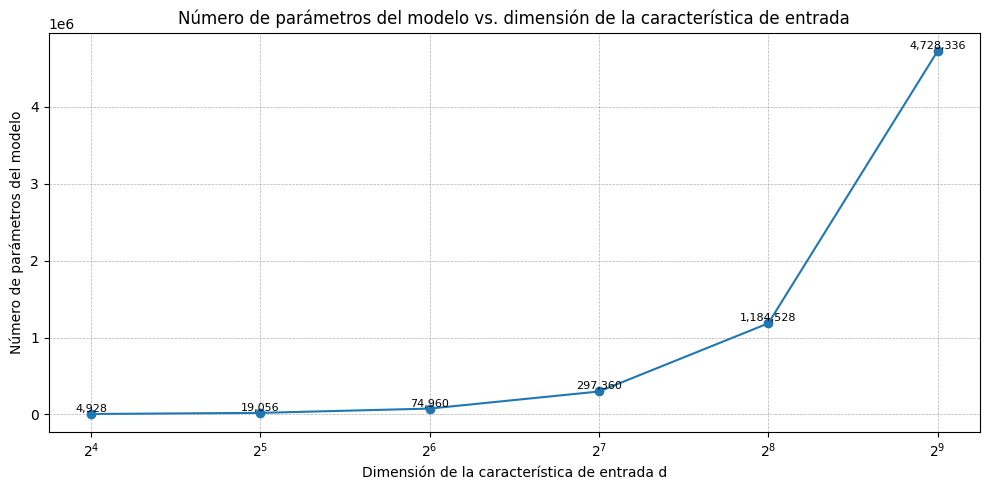

In [9]:
import matplotlib.pyplot as plt

# Variación del número de parámetros del modelo cuando crece el número de features
params = []
ds = [16, 32, 64, 128, 256, 512]
for d in ds:
    model = Sequential(
        "x, edge_index",
        [
            (TAGConv(d, d, K=5, normalize=True, bias=True), "x, edge_index -> x"),
            ReLU(),
            (TAGConv(d, d, K=5, normalize=True, bias=True), "x, edge_index -> x"),
            ReLU(),
            (TAGConv(d, d, K=5, normalize=True, bias=True), "x, edge_index -> x"),
            ReLU(),
            Linear(d, 16),
        ],
    )
    n_model = sum(p.numel() for p in model.parameters() if p.requires_grad)
    params.append(n_model)
    print(f"d={d:>3}  params(model)={n_model:>7}")


plt.figure(figsize=(10, 5))
plt.plot(ds, params, marker="o")
for x, y in zip(ds, params):
    plt.text(x, y, f"{y:,}", ha="center", va="bottom", fontsize=8)
plt.xscale("log", base=2)
plt.xlabel("Dimensión de la característica de entrada d")
plt.ylabel("Número de parámetros del modelo")
plt.title("Número de parámetros del modelo vs. dimensión de la característica de entrada")
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.show()


## Open Graph Benchmark (OGB)


Open Graph Benchmark (OGB) es una colección de datasets reales y de gran escala para el aprendizaje automático en grafos. Los datasets pueden descargarse automáticamente usando el **OGB Data Loader**.

En lo que resta de este laboratorio utilizaremos el dataset `ogbn-arxiv`. Este dataset consiste en un único grafo dirigido y sin pesos, donde los nodos representan artículos y las aristas indican si un paper es citado por otro.

A cada paper le corresponde un vector de features de dimensión $d$, que se obtiene tras realizar el promedio de los embeddings de texto (skip-gram model) del título y el abstract del paper.

La idea de esta parte es entrenar una GNN para predecir las categorías de cada paper dentro de un total de 40 categorías posibles.


El dataset está dividido en sets de entrenamiento, validación y testeo con el siguiente criterio:
- **Set de entrenamiento:** Papers publicados hasta el 2017
- **Set de validación:** Papers publicados en 2018
- **Set de testo:** Papers publicados en 2019

## PyG Data

Usaremos las clases `dataset` y `Data` de PyG para cargar el conjunto de datos `ogbn-arxiv`.

Los objetos `dataset` de PyG generalmente almacenan una lista de objetos `torch_geometric.data.Data`, cada uno de estos suele representar un grafo. Para obtener el objeto `Data` basta simplemente con indexar sobre el objeto `dataset`.

Para más información sobre como utilizar estas clases se sugiere leer la [documentación](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data) de PyG.



---



Utilice el bloque de código a continuación para hacer el setup de los datos.

In [10]:
import torch_geometric.transforms as T
from ogb.nodeproppred import PygNodePropPredDataset
from torch_geometric.data.data import DataEdgeAttr, DataTensorAttr
from torch_geometric.data.storage import GlobalStorage

dataset_name = 'ogbn-arxiv'

# Hubo un cambo en PyTorch 2.6 que rompe la carga del dataset
# Las líneas de abajo lo solucionan
torch.serialization.add_safe_globals([DataEdgeAttr])
torch.serialization.add_safe_globals([DataTensorAttr])
torch.serialization.add_safe_globals([GlobalStorage])

# Cargar el dataset
dataset = PygNodePropPredDataset(name=dataset_name,
                                 root = './tmp/' + dataset_name, # Lo guardo en una carpeta temporal para no tener que descargarlo de nuevo
                                 transform=T.Compose([T.ToUndirected(),
                                                      T.ToSparseTensor()])) # Transformo los grafos a no dirigidos, y luego a formato esparso, ver https://github.com/pytorch/pytorch/issues/111359

print('El {} dataset tiene {} grafos'.format(dataset_name, len(dataset)))

# Extraer el grafo
data = dataset[0]

Downloaded 0.08 GB: 100%|██████████| 81/81 [00:12<00:00,  6.67it/s]


Extracting ./tmp/ogbn-arxiv/arxiv.zip


Processing...


Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 1/1 [00:00<00:00, 11275.01it/s]


Converting graphs into PyG objects...


100%|██████████| 1/1 [00:00<00:00, 3640.89it/s]

Saving...
El ogbn-arxiv dataset tiene 1 grafos



Done!
/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/sparse.py:276: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  adj = torch.sparse_csr_tensor(


7. ¿Cuántos features poseen los nodos del grafo `ogbn-arxiv`?

In [11]:
data.num_features

128

La celda siguiente divide el conjunto de datos en sets de entrenamiento, validación y testeo, que usaremos luego para el entrenamiento del modelo.

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
data = data.to(device)

split_idx = dataset.get_idx_split()

train_idx = split_idx['train'].to(device)
val_idx = split_idx['valid'].to(device)
test_idx = split_idx['test'].to(device)

## Modelo GCN

Procederemos a construir nuestra GNN para luego aplicarla al conjunto de datos `ogbn-arxiv` con el fin de predecir la categoría de cada paper.

8. Utilice el bloque de código a continuación para construir una **GNN** de $n$ capas como el de la figura. Por simplicidad, considerar en cada GCN un filtro de orden `K=1`.

Se recomienda utilizar las siguientes funciones:
- `TAGConv`: implementación de **GCN** de **PyTorch Geometric** que vimos anteriormente.
- `torch.nn.functional.relu`: función de **PyTorch** que aplica la activación **ReLU**.
- `torch.nn.BatchNorm1d`: módulo de **PyTorch** que aplica normalización por lotes (batch) a entradas de 1 dimensión para estabilizar y acelerar el entrenamiento de la red.
- `torch.nn.LogSoftmax`: módulo de **PyTorch** que aplica la función **LogSoftmax**.
- `torch.nn.functional.dropout`: función de PyTorch que aplica la ténica de regularización dropout. La misma consiste en desactivar aleatoriamente algunas neuronas de la red durante el entrenamiento, evitando asi el sobreajuste.







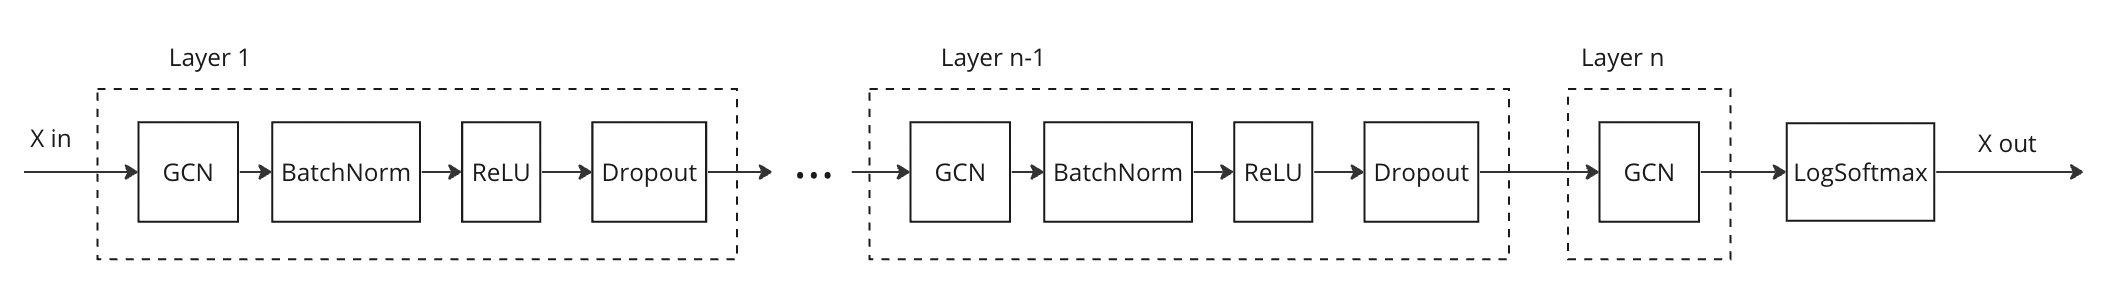

In [25]:
import torch
import torch.nn.functional as F
from torch.nn import ReLU

class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers,
                 dropout, K=1):
        super(GCN, self).__init__()

        self.num_layers = num_layers
        self.dropout = dropout
        self.convs = torch.nn.ModuleList()

        ############# Tu código aquí ############
        self.bns = torch.nn.ModuleList()

        self.softmax = None

        # Primera capa
        self.convs.append(
            TAGConv(input_dim, hidden_dim, K=K)
        )
        self.bns.append(torch.nn.BatchNorm1d(hidden_dim))

        # Capas intermedias
        for _ in range(self.num_layers - 2):
            self.convs.append(
                TAGConv(hidden_dim, hidden_dim, K=K)
            )
            self.bns.append(torch.nn.BatchNorm1d(hidden_dim))

        # Capa de salida
        self.convs.append(
            TAGConv(hidden_dim, output_dim, K=K)
        )

        self.softmax = torch.nn.LogSoftmax(dim=-1)

      #########################################

    def forward(self, x, edge_index):
      """
      Args:
          x: Tensor con la señal del grafo con dimensiones [num_nodes, input_dim]
          edge_index: Matriz de adyacencia del grafo en formato comprimido
      """

      ############# Tu código aquí ############

      out = None

      for i in range(self.num_layers - 1):
            x = self.convs[i](x, edge_index)
            x = self.bns[i](x)
            x = F.relu(x, inplace=True)
            x = F.dropout(x, p=self.dropout, training=self.training)

      # Última GCN + LogSoftmax
      x = self.convs[-1](x, edge_index)
      out = self.softmax(x)

      #########################################


      return out

Para el entrenamiento del modelo se utilizarán las siguientes funciones:

- La función `train()` recibe como entrada el modelo `model`, el conjunto de datos `data`, los índices correspondientes a las muestras de entrenamiento (`train_idx`), un algoritmo de optimización `optimizer` y una función de pérdida `loss_fn`. Devuelve la pérdida calulada.

- La función de `evaluate()` recibe como entrada el modelo `model`, el conjunto de datos `data` y los índices correspondientes a las muestras de los conjuntos de entrenamiento, validación y testeo (`train_idx`, `val_idx`, `test_idx`).
Devuelve las métricas de accuracy correspondientes a los diferentes conjuntos.

9. Complete el siguiente bloque de código, implementando las funciones mecionadas.


In [26]:
def train(model, data, train_idx, optimizer, loss_fn):

  loss = 0
  model.train()

  ############# Tu código aquí ############
  ## Notas:
  ## 1. Poner los gradientes del optimizador en 0
  ## 2. Pasar la señal data por el modelo
  ## 3. Quedarse con la salida del modelo de las muestras de entrenamiento
  ## 4. Calcular la función de costo entre esa salida y las etiquetas reales del conjunto de entrenamiento
  #########################################
  optimizer.zero_grad()
  out = model(data.x, data.adj_t)
  out_train = out[train_idx]
  y_train = data.y[train_idx].view(-1)
  loss = loss_fn(out_train, y_train)
  loss.backward()
  optimizer.step()

  return loss


@torch.no_grad() ## Para desactivar el calculo y actualizacion de los gradientes dentro de la función evaluate()
def evaluate(model, data, train_idx, val_idx, test_idx):

  model.eval()
  ############# Tu código aquí ############

  out = model(data.x, data.adj_t)

  #########################################

  y_pred = out.argmax(dim=-1, keepdim=True)

  evaluator = Evaluator(name='ogbn-arxiv')

  train_acc = evaluator.eval({
      'y_true': data.y[train_idx],
      'y_pred': y_pred[train_idx],
  })['acc']
  valid_acc = evaluator.eval({
      'y_true': data.y[val_idx],
      'y_pred': y_pred[val_idx],
  })['acc']
  test_acc = evaluator.eval({
      'y_true': data.y[test_idx],
      'y_pred': y_pred[test_idx],
  })['acc']

  return train_acc, valid_acc, test_acc

Inicializamos el modelo y lo entrenamos.

In [27]:
from ogb.nodeproppred import Evaluator

## Inicializamos los parámetros
args = {
    'device': device,
    'hidden_dim': 128,
    'num_layers': 2,
    'dropout': 0.5,
    'lr': 0.01,
    'epochs': 100,
}

## Inicializamos el modelo
model = GCN(data.num_features,
            args['hidden_dim'],
            dataset.num_classes,
            args['num_layers'],
            args['dropout']
            )
model.to(device)

## Definimos el optimizer y la función de pérdida
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
loss_fn = torch.nn.CrossEntropyLoss()

print(model)

GCN(
  (convs): ModuleList(
    (0): TAGConv(128, 128, K=1)
    (1): TAGConv(128, 40, K=1)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (softmax): LogSoftmax(dim=-1)
)


In [28]:
import copy

best_valid_acc = 0

## Loop de entrenamiento
for epoch in range(1, 1 + args["epochs"]):

  loss = train(model, data, train_idx, optimizer, loss_fn)
  train_acc, valid_acc, test_acc = evaluate(model, data, train_idx, val_idx, test_idx)

  if valid_acc > best_valid_acc:
      best_valid_acc = valid_acc
      best_model = copy.deepcopy(model)
      best_epoch = epoch

  if epoch % 10 == 0:
    print(f'Epoch: {epoch:02d}, '
          f'Loss: {loss:.4f}, '
          f'Train: {100 * train_acc:.2f}%, '
          f'Valid: {100 * valid_acc:.2f}% '
          f'Test: {100 * test_acc:.2f}%')

Epoch: 10, Loss: 1.7256, Train: 55.27%, Valid: 58.03% Test: 57.19%
Epoch: 20, Loss: 1.4039, Train: 62.46%, Valid: 62.79% Test: 61.91%
Epoch: 30, Loss: 1.2690, Train: 65.39%, Valid: 65.61% Test: 64.29%
Epoch: 40, Loss: 1.1849, Train: 67.54%, Valid: 67.52% Test: 66.33%
Epoch: 50, Loss: 1.1294, Train: 68.82%, Valid: 68.51% Test: 67.68%
Epoch: 60, Loss: 1.0966, Train: 69.93%, Valid: 69.21% Test: 68.28%
Epoch: 70, Loss: 1.0610, Train: 70.59%, Valid: 69.48% Test: 67.93%
Epoch: 80, Loss: 1.0429, Train: 71.20%, Valid: 69.72% Test: 68.46%
Epoch: 90, Loss: 1.0225, Train: 71.83%, Valid: 70.22% Test: 68.95%
Epoch: 100, Loss: 1.0045, Train: 72.23%, Valid: 70.33% Test: 69.26%


Si su implementación es correcta, debería lograr un accuracy en test del entorno a 69%.

In [29]:
best_result = evaluate(best_model, data, train_idx, val_idx, test_idx)
train_acc, valid_acc, test_acc = best_result
print(f'Best model: '
      f'Epoch: {best_epoch:.2f}, '
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * valid_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Best model: Epoch: 99.00, Train: 72.21%, Valid: 70.49% Test: 69.44%


10. Pruebe re-entrenar modificando algunos parámetros del entrenamiento y del modelo, como ser el número de épocas (`epochs`), el número de capas (`num_layers`), las dimensiones ocultas (`hidden_dim`) y el valor el orden del filtro (`K`). Comente los resultados obtenidos y reporte la mejor performance (en test) lograda.

**Nota:** Debería poder lograr un incremento de por lo menos un 2% del accuracy en test.

In [30]:
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator

# Modifique los parámetros a su conveniencia
args = {
    'device': device,
    'hidden_dim': 256,
    'num_layers': 3,
    'dropout': 0.5,
    'lr': 0.01,
    'epochs': 200,
    'K' : 3
}

## Inicializamos el modelo
model = GCN(data.num_features,
            args['hidden_dim'],
            dataset.num_classes,
            args['num_layers'],
            args['dropout'],
            args['K']
            )
model.to(device)

## Definimos el optimizer y la función de pérdida
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
loss_fn = torch.nn.CrossEntropyLoss()

print(model)

GCN(
  (convs): ModuleList(
    (0): TAGConv(128, 256, K=3)
    (1): TAGConv(256, 256, K=3)
    (2): TAGConv(256, 40, K=3)
  )
  (bns): ModuleList(
    (0-1): 2 x BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (softmax): LogSoftmax(dim=-1)
)


In [31]:
import copy

## Loop de entrenamiento

best_valid_acc = 0

for epoch in range(1, 1 + args["epochs"]):

  loss = train(model, data, train_idx, optimizer, loss_fn)
  train_acc, valid_acc, test_acc = evaluate(model, data, train_idx, val_idx, test_idx)

  if valid_acc > best_valid_acc:
      best_valid_acc = valid_acc
      best_model = copy.deepcopy(model)
      best_epoch = epoch

  if epoch % 10 == 0:
    print(f'Epoch: {epoch:02d}, '
          f'Loss: {loss:.4f}, '
          f'Train: {100 * train_acc:.2f}%, '
          f'Valid: {100 * valid_acc:.2f}% '
          f'Test: {100 * test_acc:.2f}%')

Epoch: 10, Loss: 1.7178, Train: 39.71%, Valid: 33.25% Test: 37.12%
Epoch: 20, Loss: 1.3231, Train: 59.69%, Valid: 62.74% Test: 62.54%
Epoch: 30, Loss: 1.1910, Train: 65.87%, Valid: 65.52% Test: 63.47%
Epoch: 40, Loss: 1.1079, Train: 68.15%, Valid: 68.25% Test: 67.05%
Epoch: 50, Loss: 1.0511, Train: 69.77%, Valid: 69.42% Test: 68.12%
Epoch: 60, Loss: 1.0077, Train: 70.95%, Valid: 70.53% Test: 69.14%
Epoch: 70, Loss: 0.9750, Train: 71.55%, Valid: 70.33% Test: 68.35%
Epoch: 80, Loss: 0.9463, Train: 72.32%, Valid: 71.00% Test: 68.92%
Epoch: 90, Loss: 0.9249, Train: 73.07%, Valid: 71.67% Test: 70.18%
Epoch: 100, Loss: 0.9033, Train: 73.61%, Valid: 72.15% Test: 70.82%
Epoch: 110, Loss: 0.8850, Train: 73.89%, Valid: 72.48% Test: 70.99%
Epoch: 120, Loss: 0.8659, Train: 73.87%, Valid: 72.38% Test: 70.80%
Epoch: 130, Loss: 0.8497, Train: 74.55%, Valid: 72.78% Test: 71.89%
Epoch: 140, Loss: 0.8342, Train: 74.86%, Valid: 72.41% Test: 70.66%
Epoch: 150, Loss: 0.8249, Train: 75.32%, Valid: 72.96% Te

In [32]:
best_result = evaluate(best_model, data, train_idx, val_idx, test_idx)
train_acc, valid_acc, test_acc = best_result
print(f'Best model: '
      f'Epoch: {best_epoch:.2f}, '
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * valid_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Best model: Epoch: 195.00, Train: 76.89%, Valid: 73.40% Test: 72.22%


# Graph Attention (Opcional)

Los mecanismos de atención se han convertido en el estado del arte en muchas tareas basadas en secuencias, como la traducción automática y el aprendizaje de representaciones semánticas de texto e imágenes.

Uno de los principales beneficios de los mecanismos basados en la atención es su capacidad para enfocarse en las partes más relevantes de la entrada para tomar decisiones. A continuación veremos cómo se pueden utilizar estos mecanismos en redes de grafos. Particularmente, implementaremos una **Graph Attention Network (GAT)** la cual usaremos para resolver nuestro problema de clasificación de nodos en el conjunto de datos `ogb-arxiv`.

Una limitante de las **GCNs** es que se brinda la misma importancia a todos los vecinos por igual. Las redes **GAT** en cambio, consideran pesos que consideran pesos que permiten diferenciar la importancia relativa de cada vecino.

> $$\mathbf{y} = \sum_{k=0}^{K} \mathbf{S}^k \mathbf{x} h_k \Rightarrow  \mathbf{y} = \sum_{k=0}^{K} \alpha_{ij} \mathbf{x} h_k$$



**Cómo funciona el mecanismo de Graph Attention?**

Los coeficientes de attention $\alpha_{ij}$ dependen del vector (embedding) de los nodos $i$ y $j$:

**Función de scoring:**

> $$e(\mathbf{x}_i, \mathbf{x}_j) = \text{LeakyReLU}(a^T[\mathbf{H}\mathbf{x}_i||\mathbf{H}\mathbf{x}_j]) = \text{LeakyReLU}(a_1^T\mathbf{H}\mathbf{x}_i+ a_2^T\mathbf{H}\mathbf{x}_j)$$

**Función de attention:**

> $$\alpha_{ij} = \text{softmax} (e(\mathbf{x}_i, \mathbf{x}_j)) = \frac{\exp(e(\mathbf{x}_i, \mathbf{x}_j))}{\sum_{j'\in N_i}\exp(e(\mathbf{x}_i, \mathbf{x}_{j'})}$$


A su vez es posible considerar varios coeficientes por capa ($K$ valores de $\alpha^k_{i,j}$), lo que lleva a un **Multi-headed attention**.

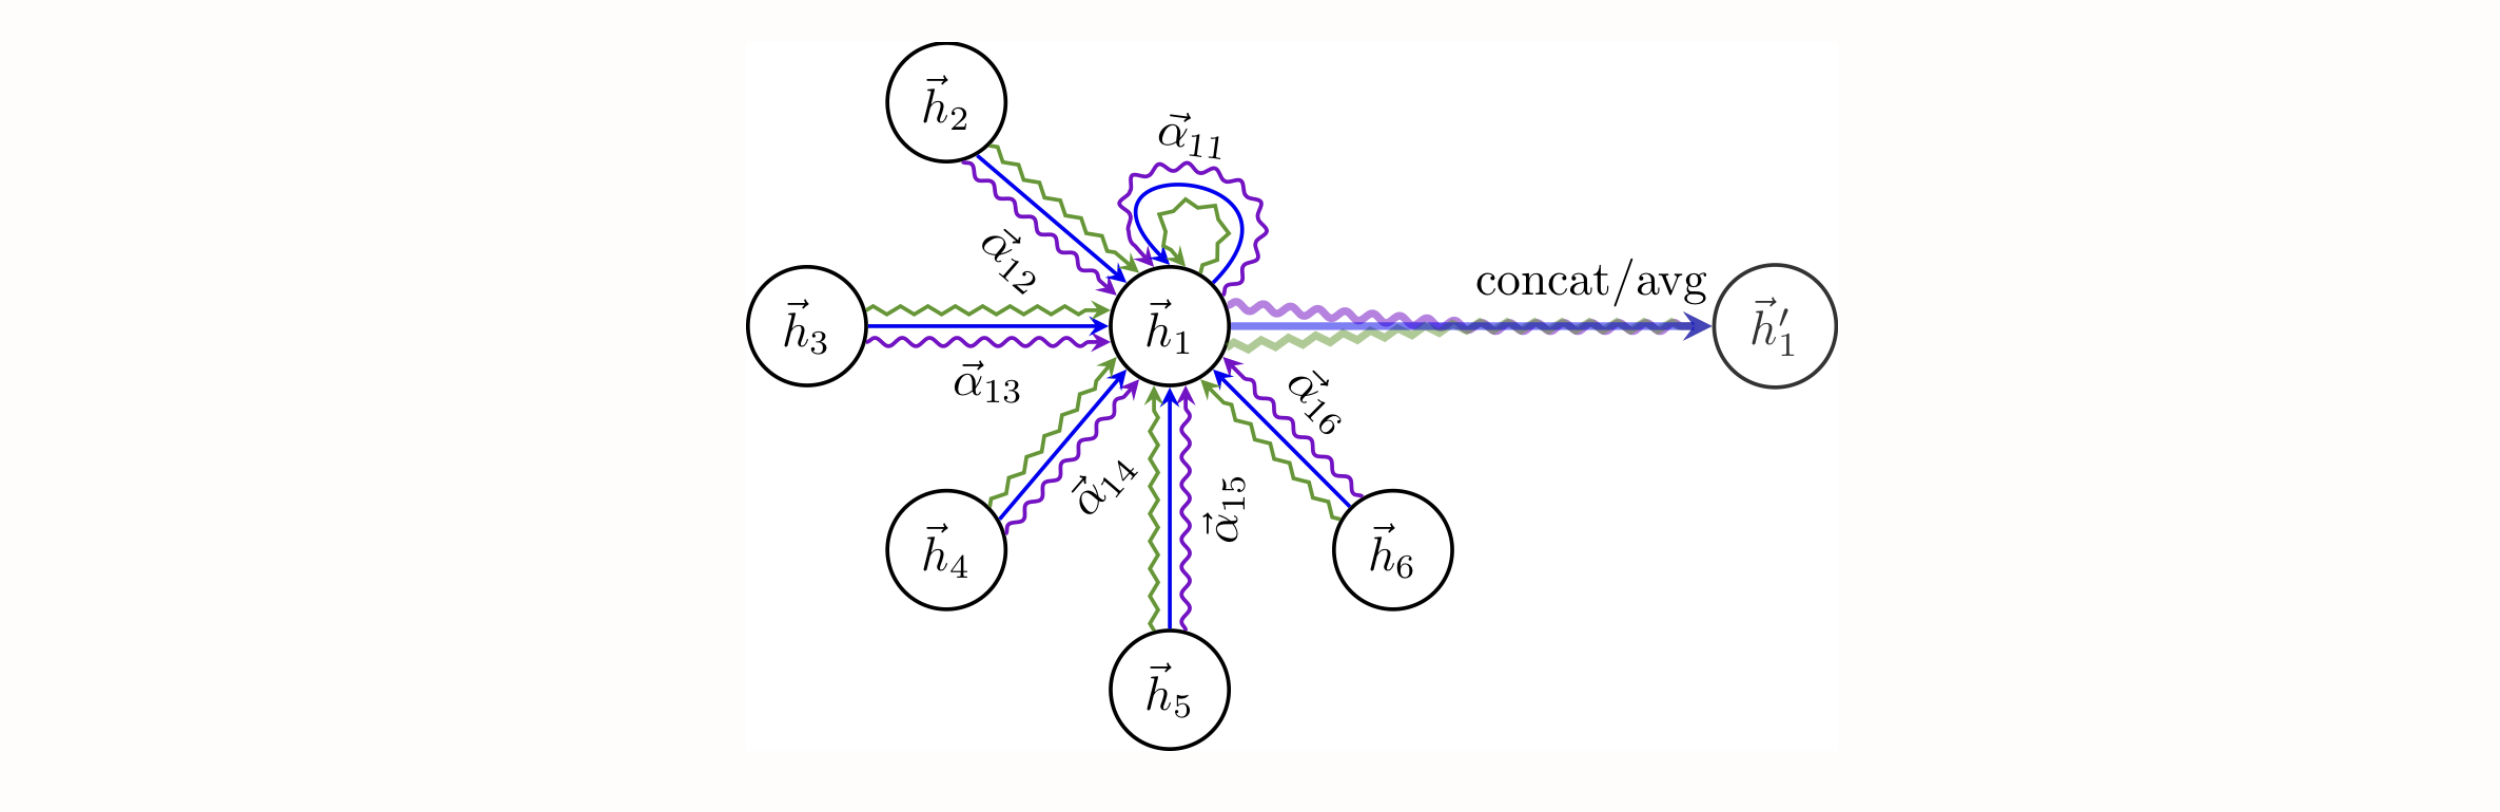


11. Utilice el código a continuación para implementar su versión de **graph attention** considerando únicamente una head.

In [ ]:
class GAT_Block(nn.Module):
    def __init__(self, c_in, c_out, alpha=0.2):
        super().__init__()

        self.lin = nn.Linear(c_in, c_out, bias=False)
        self.a = nn.Parameter(torch.Tensor(1, 2*c_out))
        self.leakyrelu = nn.LeakyReLU(alpha)

    def forward(self, x, edge_index, return_attn_matrix=False):
        """
        Args:
            x: Tensor con la señal del grafo con dimensiones [num_nodes, c_in]
            edge_index: Matriz de adyacencia del grafo en formato comprimido
        """
        # TODO: Implementar una función que dada una señal X y un grafo edge_index
        # aplique graph attention (con una única head) y devuelva la señal Y resultante

        ## Paso 1: Pasaje por capa lineal
        ############# Tu código aquí ############

        #########################################


        ## Paso 2: Concatenar vector de entrada [Hxi || Hxj]
        ## Considerar únicamente los i, j donde exista una arista
        ## Puede ser de utilidad la función torch.index_select()
        ############# Tu código aquí ############

        #########################################


        ## Paso 3: Calcular los pesos de attention
        ## Puede ser de utilidad la función torch.einsum()
        ############# Tu código aquí ############

        #########################################


        ## Paso 4: Construir matriz de attention
        adj_matrix = pyg.utils.to_dense_adj(edge_index)
        attn_matrix = attn_weights.new_zeros(adj_matrix.shape).fill_(-9e15)

        ############# Tu código aquí ############

        #########################################

        ## Paso 5: Calcular la salida final
        ## Puede ser de utilidad la función torch.einsum()
        ############# Tu código aquí ############

        #########################################

        if return_attn_matrix:
            return x, attn_matrix
        else:
            return x

Para verificar la clase implementada anteriormente, consideremos nuevamente un grafo no-dirigido dado por la siguiente matriz de adyacencia $\mathbf{A}$ y una señal $\mathbf{X}$, donde:

$$\mathbf{A} = \begin{bmatrix}
    0 & 1 & 0 & 0\\
    1 & 0 & 1 & 1\\
    0 & 1 & 0 & 1\\
    0 & 1 & 1 & 0
\end{bmatrix} , \ \ \ \ \mathbf{X} = \begin{bmatrix}
    0 & 1 \\
    2 & 3 \\
    4 & 5 \\
    6 & 7
\end{bmatrix}$$

In [ ]:
X = torch.arange(8, dtype=torch.float32).view(4, 2)
A = torch.Tensor([[0, 1, 0, 0], [1, 0, 1, 1], [0, 1, 0, 1], [0, 1, 1, 0]])
edge_index = A.nonzero().t().contiguous()

print("Señal de entrada X:\n", X)
print("\nMatriz de adyacencia:\n", A)
print("\nMatriz de adyacencia en formato edge index:\n", edge_index)

12. Pruebe aplicar su implementación sobre el grafo y la señal $\mathbf{X}$

Por su parte **[PyTorch Geometric](https://github.com/rusty1s/pytorch_geometric)** (PyG) provee su propia implementación de **GAT** en la clase [`GATConv`](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GATConv.html#torch_geometric.nn.conv.GATConv).

13. Vuelva a computar un forward pass sobre X usando la clase `GATConv`. Compare el resultado con el obtenido en la parte anterior.

## Modelo GAT

Finalmente, procederemos a construir un modelo GAT el cual aplicaremos al conjunto de datos `ogbn-arxiv` con el fin de predecir la categorías de cada paper.

14. Implemente nuevamente el modelo del ejercicio 8, esta vez intercambiando los bloques GCN por bloques GAT.
Por simplicidad considerar una única head en las capas de attention `num_heads=1`.





In [ ]:
import torch
from torch_geometric.nn import GATConv
from torch.nn import ReLU
import torch.nn.functional as F

class GAT(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, num_layers,
               dropout, num_heads=1):
    super(GAT, self).__init__()

    self.num_layers = num_layers
    self.dropout = dropout
    self.gats = torch.nn.ModuleList()

    ############# Tu código aquí ############

    self.gats = torch.nn.ModuleList()

    self.softmax = None

    #########################################

  def forward(self, x, edge_index):
    """
    Args:
        x: Tensor con la señal del grafo con dimensiones [num_nodes, input_dim]
        edge_index: Matriz de adyacencia del grafo en formato comprimido
    """

    ############# Tu código aquí ############

    out = None

    #########################################

    return out

Ejecute las siguientes celdas para entrenar el modelo.

> **Comentario**: En el caso de tener un error de `CUDA` por memoria insuficiente, se recomienda ejecutar los siguientes comandos:
>
> ```
> import gc
torch.cuda.empty_cache()
gc.collect()
>  ```
>
> O en su defecto re-iniciar el Runtime environment de Colab y ejecutar únicamente
los bloques de celdas **Setup**, **PyG Data** y **Modelo GAT**.

In [ ]:
from ogb.nodeproppred import Evaluator

## Inicializamos los parámetros
args = {
    'hidden_dim': 128,
    'num_layers': 3,
    'dropout': 0.5,
    'lr': 0.01,
    'epochs': 200,
}

## Inicializamos el modelo
model = GAT(data.num_features,
            args['hidden_dim'],
            dataset.num_classes,
            args['num_layers'],
            args['dropout']
            )
model.to(device)

## Definimos el optimizer y la función de pérdida
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
loss_fn = torch.nn.CrossEntropyLoss()

print(model)

In [ ]:
import copy

best_valid_acc = 0

## Loop de entrenamiento
for epoch in range(1, 1 + args["epochs"]):
  loss = train(model, data, train_idx, optimizer, loss_fn)
  train_acc, valid_acc, test_acc = evaluate(model, data, train_idx, val_idx, test_idx)

  if valid_acc > best_valid_acc:
      best_valid_acc = valid_acc
      best_model = copy.deepcopy(model)
      best_epoch = epoch

  if epoch % 10 == 0:
    print(f'Epoch: {epoch:02d}, '
          f'Loss: {loss:.4f}, '
          f'Train: {100 * train_acc:.2f}%, '
          f'Valid: {100 * valid_acc:.2f}% '
          f'Test: {100 * test_acc:.2f}%')

In [ ]:
best_result = evaluate(best_model, data, train_idx, val_idx, test_idx)
train_acc, valid_acc, test_acc = best_result
print(f'Best model: '
      f'Epoch: {best_epoch:.2f}, '
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * valid_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

15. ¿Qué pasa si considera usar la clase `GATv2Conv` en lugar de `GATConv` en el armado del modelo? Nota alguna mejora en su performance? ¿Cuál es la diferencia entre estas clases?

In [ ]:
import torch
from torch_geometric.nn import GATv2Conv
from torch.nn import ReLU
import torch.nn.functional as F

class GATv2(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, num_layers,
               dropout, num_heads=1):
    super(GATv2, self).__init__()

    self.num_layers = num_layers
    self.dropout = dropout
    self.gats = torch.nn.ModuleList()

    ############# Tu código aquí ############

    self.gats = torch.nn.ModuleList()

    self.softmax = None

    #########################################

  def forward(self, x, edge_index):
    """
    Args:
        x: Tensor con la señal del grafo con dimensiones [num_nodes, input_dim]
        edge_index: Matriz de adyacencia del grafo en formato comprimido
    """

    ############# Tu código aquí ############

    out = None

    #########################################

    return out

In [ ]:
from ogb.nodeproppred import Evaluator

## Inicializamos los parámetros
args = {
    'hidden_dim': 128,
    'num_layers': 3,
    'dropout': 0.5,
    'lr': 0.01,
    'epochs': 200,
}

## Inicializamos el modelo
model = GATv2(data.num_features,
            args['hidden_dim'],
            dataset.num_classes,
            args['num_layers'],
            args['dropout']
            )
model.to(device)

## Definimos el optimizer y la función de pérdida
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
loss_fn = torch.nn.CrossEntropyLoss()

print(model)

In [ ]:
import copy

best_valid_acc = 0

## Loop de entrenamiento
for epoch in range(1, 1 + args["epochs"]):
  loss = train(model, data, train_idx, optimizer, loss_fn)
  train_acc, valid_acc, test_acc = evaluate(model, data, train_idx, val_idx, test_idx)

  if valid_acc > best_valid_acc:
      best_valid_acc = valid_acc
      best_model = copy.deepcopy(model)
      best_epoch = epoch

  if epoch % 10 == 0:
    print(f'Epoch: {epoch:02d}, '
          f'Loss: {loss:.4f}, '
          f'Train: {100 * train_acc:.2f}%, '
          f'Valid: {100 * valid_acc:.2f}% '
          f'Test: {100 * test_acc:.2f}%')

In [ ]:
best_result = evaluate(best_model, data, train_idx, val_idx, test_idx)
train_acc, valid_acc, test_acc = best_result
print(f'Best model: '
      f'Epoch: {best_epoch:.2f}, '
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * valid_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

# Agradecimientos
Este laboratorio está basado en los laboratorios 2 y 3 del curso "Machine Learning with Graphs" de la Universidad de Stanford (http://web.stanford.edu/class/cs224w/index.html).